In [1]:
# Connect to google drive via google colab libraby

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/Documents/Personal/Education/FRI/Masters/1.Letnik/1.Semester/SB/IBB-project-2/

/content/drive/MyDrive/Documents/Personal/Education/FRI/Masters/1.Letnik/1.Semester/SB/IBB-project-2


In [53]:
TEST_IMAGES_PATH = "dataset/test/images"
TEST_ANNOTATIONS_PATH = "dataset/test/annotations"
PREDICTIONS_IMAGES_PATH = "dataset/test/predictions/images"
PREDICTIONS_ANNOTATIONS_PATH = "dataset/test/predictions/annotations"

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import glob
import cv2
import keras
from tensorflow import keras
from statistics import mean

### 1. Helper functions

In [55]:
def calculate_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [56]:
def calculate_intersection(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    return intersection_area

In [57]:
def group_predictions(airplane_predictions):
    group_num = 1
    for i in range(0, len(airplane_predictions)):
        if airplane_predictions[i]["group"] != -1:
            continue
        
        airplane_predictions[i]["group"] = group_num
        ix, iy, iw, ih = airplane_predictions[i]["values"]
        for j in range(i, len(airplane_predictions)):
            jx, jy, jw, jh = airplane_predictions[j]["values"]

            intersection = calculate_intersection({"x1":ix, "x2":ix+iw, "y1":iy, "y2":iy+ih},{"x1":jx, "x2":jx+jw, "y1":jy, "y2":jy+jh})

            if intersection > 0.2:
                airplane_predictions[j]["group"] = group_num
        group_num += 1
    return airplane_predictions, group_num

In [58]:
def calculate_best_predictions(airplane_predictions, group_num):
    best_predictions = dict()
    for i in range(1, group_num):
        best_predictions[i] = dict()
        best_predictions[i]["accuracy"] = -1
        best_predictions[i]["values"] = -1

    for i in airplane_predictions:
        if i["accuracy"] > best_predictions[i["group"]]["accuracy"]:
            best_predictions[i["group"]]["accuracy"] = i["accuracy"]
            best_predictions[i["group"]]["values"] = i["values"]
    return best_predictions

In [59]:
def calculate_prediction_accuracy(best_predictions):
    annotation_file = os.path.join(TEST_ANNOTATIONS_PATH, airplane_path.split("/")[-1].split(".")[0] + ".csv")
    df = pd.read_csv(annotation_file)
    gtvalues=[]
    for row in df.iterrows():
        x1 = int(row[1][0].split(" ")[0])
        y1 = int(row[1][0].split(" ")[1])
        x2 = int(row[1][0].split(" ")[2])
        y2 = int(row[1][0].split(" ")[3])
        gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})

    ious = []
    # For each annotation of current image we calulate the IoU
    for gtval in gtvalues:
        iou = 0
        for i in best_predictions:
            x,y,w,h = best_predictions[i]["values"]

            intersection = calculate_intersection(gtval,{"x1":x, "x2":x+w, "y1":y, "y2":y+h})

            if intersection > 0.3:
                iou = calculate_iou(gtval,{"x1":x, "x2":x+w, "y1":y, "y2":y+h})
                break
        
        ious.append(iou)
    return mean(ious)

### 2. Evaluation

1. Use selective search algorithm to obtain 2000 interesting regions
2. Use prediction model to predict if region is airplane or not
3. Custom algorithm to find group inside predicted regions and choose the most relevant one (with the highest accuracy)
4. Use IoU to evaluate the prediction regions on one image
5. Average IoU to evaluate the model

In [60]:
# Load the model
model_final = keras.models.load_model('my_detector.h5')

In [61]:
selectiveSearch = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [62]:
all_ious = dict()
for e,i in enumerate(os.listdir(TEST_IMAGES_PATH)):
    airplane_path = i

    img = cv2.imread(os.path.join(TEST_IMAGES_PATH, airplane_path))
    selectiveSearch.setBaseImage(img)
    selectiveSearch.switchToSelectiveSearchFast()
    results = selectiveSearch.process()
    imout = img.copy()

    airplane_predictions = []
    for e,result in enumerate(results):
        if e < 2000:
            x, y, w, h = result
            timage = imout[y:y+h, x:x+w]
            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
            img = np.expand_dims(resized, axis=0)
            out= model_final.predict(img)
            prediction = dict()
            if out[0][0] > 0.8:
                prediction["accuracy"] = out[0][0]
                prediction["values"] = result
                prediction["group"] = -1

                airplane_predictions.append(prediction)
                # cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

    # Group predictions based on intersection of regions
    airplane_predictions, group_num = group_predictions(airplane_predictions)

    # Calculate best predictions of each group
    best_predictions = calculate_best_predictions(airplane_predictions, group_num)

    # Plot best prediction rectangles on test images
    for i in best_predictions:
        x,y,w,h = best_predictions[i]["values"]
        cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

    predicted_path = os.path.join(PREDICTIONS_IMAGES_PATH, airplane_path)
    cv2.imwrite(predicted_path, imout)

    # Print to file
    predicted_path = os.path.join(PREDICTIONS_ANNOTATIONS_PATH, airplane_path.split(".")[0] + ".csv")
    df = pd.DataFrame(columns = ['x', 'y', 'w', 'h'])
    for i in best_predictions:
        df_length = len(df)
        df.loc[df_length] = best_predictions[i]["values"]
    df.to_csv(predicted_path, index=False)

    # Calculate IoU for each predicted image
    iou_accuracy = calculate_prediction_accuracy(best_predictions)

    all_ious[airplane_path] = iou_accuracy

In [71]:
all_ious

{'airplane_301.jpg': 0.8588340554403612,
 'airplane_302.jpg': 0.396099024756189,
 'airplane_303.jpg': 0.7326309511976941,
 'airplane_304.jpg': 0.6366924049608966,
 'airplane_305.jpg': 0.7207757128267793,
 'airplane_306.jpg': 0.7165676028306482,
 'airplane_307.jpg': 0.21692374098307526,
 'airplane_308.jpg': 0.31275375879077183,
 'airplane_309.jpg': 0.4660277253865922,
 'airplane_310.jpg': 0.24909947353837628,
 'airplane_311.jpg': 0.5278350877931702,
 'airplane_312.jpg': 0.40625210196366407,
 'airplane_313.jpg': 0.5453353536471084,
 'airplane_314.jpg': 0.4377214687194526,
 'airplane_315.jpg': 0.8016577921691564,
 'airplane_316.jpg': 0,
 'airplane_317.jpg': 0.7460539595710791,
 'airplane_318.jpg': 0.2448359659781288,
 'airplane_319.jpg': 0.17239835828792885,
 'airplane_320.jpg': 0.7765549948318843,
 'airplane_321.jpg': 0.6522951878250507,
 'airplane_322.jpg': 0.7545933109315732,
 'airplane_323.jpg': 0.6397558714462299,
 'airplane_324.jpg': 0.5974715320930601,
 'airplane_325.jpg': 0.702040

In [74]:
mean_accuracy = mean(all_ious.values())
mean_accuracy

0.5601080575894383

In [67]:
import csv

In [77]:
accuracies_path = "dataset/test/predictions/accuracies.csv"
with open(accuracies_path, 'w') as file:
    writer = csv.writer(file)
    for key, value in all_ious.items():
       writer.writerow([key, value])

In [78]:
mean_accuracy_path = "dataset/test/predictions/mean_accuracy.csv"
with open(mean_accuracy_path, 'w') as file:
    writer = csv.writer(file)
    writer.writerow([mean_accuracy])

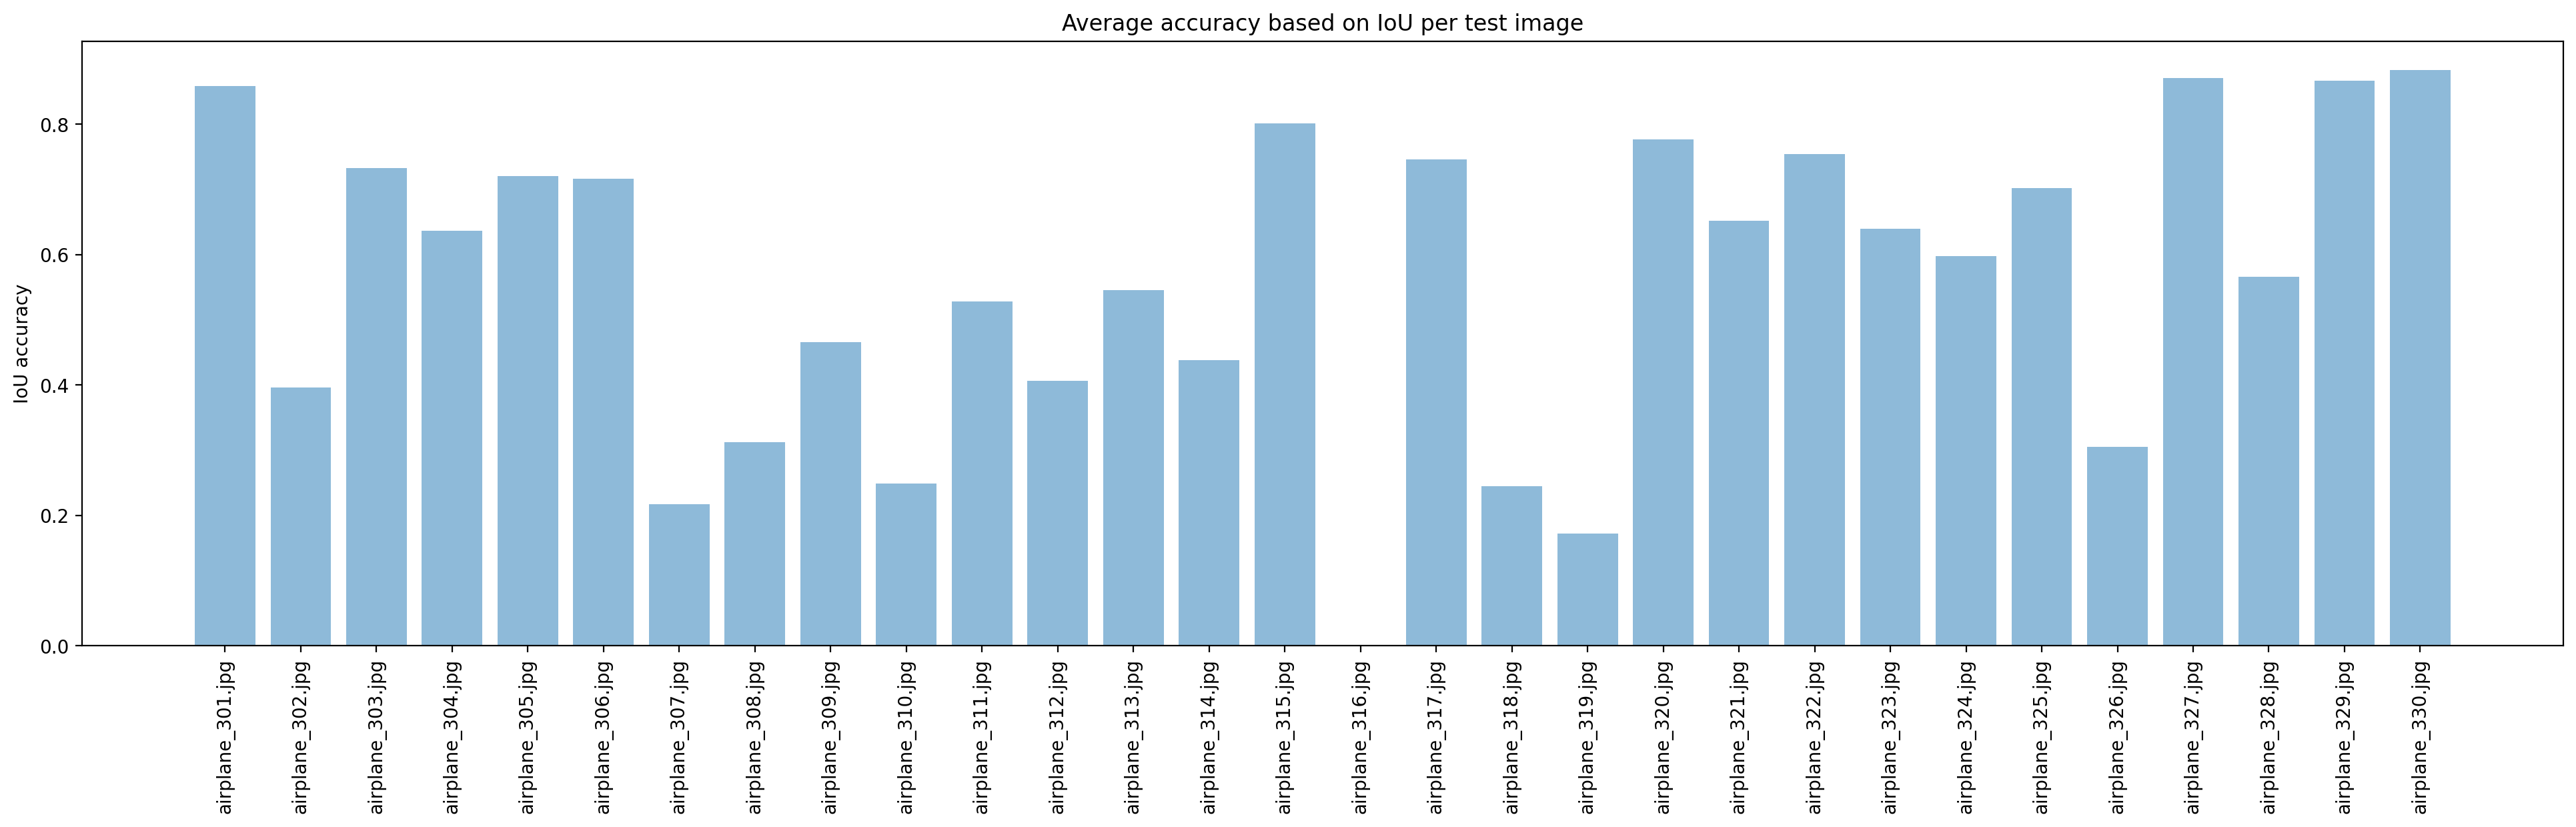

In [93]:
objects = all_ious.keys()
y_pos = np.arange(len(objects))
performance = all_ious.values()

fig = plt.figure(figsize=(24, 6), dpi=200)
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=90)
plt.ylabel('IoU accuracy')
plt.title('Average accuracy based on IoU per test image')
fig.savefig('metrics/accuracies.png', dpi=fig.dpi)
plt.show()